In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

import seaborn as sns
import shap

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

In [2]:
pd.set_option('display.width', 5000) 
pd.set_option('display.max_colwidth', -1) 
pd.set_option('display.max_columns', 60)

In [3]:
processed_data_path  ="/Users/elenasmith/Documents/personal/water_git/data/interim/"

In [4]:
prod = pd.read_csv("{}2_explore_unit_correction___prod_before_unit_conversion.csv".format(processed_data_path))
deliv= pd.read_csv("{}2_explore_unit_correction___deliv_before_unit_conversion.csv".format(processed_data_path))
deliv['Date'] = pd.to_datetime(deliv['Date'])
systems = pd.read_csv("https://data.ca.gov/sites/default/files/Public%20Potable%20Water%20Systems%20FINAL%2006-22-2018_0.csv")

deliv_pivot = pd.read_csv("{}1_initial_eda___deliv.csv".format(processed_data_path))
deliv_pivot['Date'] = pd.to_datetime(deliv_pivot['Date'])
prod_pivot = pd.read_csv("{}1_initial_eda___prod.csv".format(processed_data_path))

deliv_gpcd_in_original = pd.read_csv("{}3_explore_gpcd___gpcdFromOriginalReport.csv".format(processed_data_path))
deliv_gpcd_in_original['Date'] = pd.to_datetime(deliv_gpcd_in_original['Date'])

In [5]:
############
# Drop records without units reported; we already know those are incorrect 
#################

In [6]:
noUnits = deliv[deliv['Delivered.Water.Units AS ORIGINALLY REPORTED']=="-"]

In [7]:
print(deliv.shape)
deliv = deliv[deliv['Delivered.Water.Units AS ORIGINALLY REPORTED']!="-"]
print(deliv.shape)

(78489, 34)
(75625, 34)


In [8]:
############
# Verify that we have one record per pwsid/date
#################

In [9]:
deliv['key'] = deliv[['Water.System.Name','Date']].apply(lambda x: "{}_{}".format(x[0],x[1]),axis=1)

In [10]:
deliv.key.value_counts()[0:5]

IID DROP FOUR_2016-11-01 00:00:00                     1
CHANNEL TECHNOLOGIES GROUP LLC_2016-03-01 00:00:00    1
AWA LA MEL HEIGHTS #3_2015-06-01 00:00:00             1
GOLDEN STATE WC - PLACENTIA_2014-04-01 00:00:00       1
CITY OF SUSANVILLE_2015-03-01 00:00:00                1
Name: key, dtype: int64

In [11]:
# What % of records have units reported incorrectly?
deliv['original_units_incorrect'].value_counts() / deliv.shape[0]

0    0.958664
1    0.041336
Name: original_units_incorrect, dtype: float64

In [12]:
incorrectByYear = deliv[['Year','original_units_incorrect']].groupby('Year').agg({'original_units_incorrect':['sum','count']}).reset_index()
incorrectByYear['pct'] = incorrectByYear[('original_units_incorrect', 'sum')] / incorrectByYear[('original_units_incorrect', 'count')]
incorrectByYear

Year original_units_incorrect              pct
                             sum  count          
0  2013  630                      14873  0.042359
1  2014  588                      16080  0.036567
2  2015  1126                     21381  0.052664
3  2016  782                      23291  0.033575

In [13]:
############
# Create features: GPCD calculated from value in "WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS", 
# but assume the value is in the original units
#################

In [14]:
print(deliv.shape)
deliv = deliv.merge(deliv_gpcd_in_original[['PWSID','Date','gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons','gpcd_numeric']].drop_duplicates(),
                   on = ['PWSID','Date'],
                   how="left")
print(deliv.shape)
predictors = ['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']

(75625, 34)
(75625, 36)


In [15]:
deliv[(pd.isnull(deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'])==False)
                  & (deliv['original_units_incorrect']==1)]['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'].describe(percentiles=[0.05,0.1,0.5,0.9,0.95])

count    2.460000e+03
mean     inf         
std     NaN          
min      5.996342e-05
5%       4.510043e-04
10%      1.114041e-01
50%      1.396206e+04
90%      4.741685e+07
95%      1.579959e+08
max      inf         
Name: gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons, dtype: float64

In [16]:
deliv[(pd.isnull(deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'])==False)
                  & (deliv['original_units_incorrect']==0)]['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons'].describe(percentiles=[0.05,0.1,0.5,0.9,0.95])

count    7.071900e+04
mean     inf         
std     NaN          
min     -2.915576e+02
5%       1.904032e+00
10%      1.065000e+01
50%      9.691828e+01
90%      3.475924e+02
95%      6.110248e+02
max      inf         
Name: gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons, dtype: float64

In [17]:
############
# Create features: Population of Service Area
#################

In [18]:
predictors = predictors + ['Population Of Service Area',]

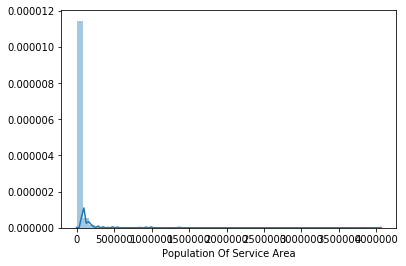

In [19]:
sns.distplot(deliv[pd.isnull(deliv['Population Of Service Area'])==False]['Population Of Service Area'])
plt.show()

In [20]:
deliv[(pd.isnull(deliv['Population Of Service Area'])==False)
                  & (deliv['original_units_incorrect']==1)]['Population Of Service Area'].describe(percentiles=[0.05,0.1,0.5,0.9,0.95])

count    3126.000000  
mean     13430.112924 
std      54398.497810 
min      0.000000     
5%       40.000000    
10%      73.000000    
50%      1000.000000  
90%      29867.000000 
95%      48165.000000 
max      486189.000000
Name: Population Of Service Area, dtype: float64

In [21]:
deliv[(pd.isnull(deliv['Population Of Service Area'])==False)
                  & (deliv['original_units_incorrect']==0)]['Population Of Service Area'].describe(percentiles=[0.05,0.1,0.5,0.9,0.95])
# Correct Units have higher median; larger service areas may have more staff to help ensure accurate reporting?#

count    7.161300e+04
mean     2.453112e+04
std      1.326244e+05
min      0.000000e+00
5%       2.500000e+01
10%      4.500000e+01
50%      8.650000e+02
90%      5.699800e+04
95%      1.033400e+05
max      4.061504e+06
Name: Population Of Service Area, dtype: float64

In [22]:
############
# Create features: Water System Classification
#################

In [23]:
deliv['Water.System.Classification'].value_counts(dropna=False)

Community Water System                                      32418
Large Water System                                          29787
Nontransient Noncommunity Water System                      6826 
Transient Noncommunity Water System                         5501 
NaN                                                         1018 
Local Government                                            33   
Privately owned, PUC-regulated, for profit water company    30   
Privately owned business (non-community)                    12   
Name: Water.System.Classification, dtype: int64

In [24]:
# Local Govt / Privately Owned have few records; all are correct
# Transient Noncommunity and Community Water are most likely to have incorrect units
deliv[['Water.System.Classification','original_units_incorrect']].groupby(['Water.System.Classification']).mean().reset_index().sort_values('original_units_incorrect')

,Water.System.Classification,original_units_incorrect
2,Local Government,0.000000
4,Privately owned business (non-community),0.000000
5,"Privately owned, PUC-regulated, for profit water company",0.000000
3,Nontransient Noncommunity Water System,0.008936
1,Large Water System,0.038977
0,Community Water System,0.047381
6,Transient Noncommunity Water System,0.065624


In [25]:
deliv['Water.System.Classification_mod'] = deliv['Water.System.Classification']
deliv.loc[pd.isnull(deliv['Water.System.Classification']),'Water.System.Classification_mod'] = "NA"
deliv.loc[deliv['Water.System.Classification_mod'].str.contains("Privately"),'Water.System.Classification_mod'] = "Private"

In [26]:
one_hot = pd.get_dummies(deliv['Water.System.Classification_mod'])
print(deliv.shape)
predictors = predictors +  list(one_hot.columns.values)
deliv = deliv.join(one_hot)
print(deliv.shape)

(75625, 37)
(75625, 44)


In [27]:
############
# Create features: Original units reported
#################

In [28]:
# CCF is most likely to be incorrect
# AF is least likely to be incorrect
deliv[['Delivered.Water.Units AS ORIGINALLY REPORTED','original_units_incorrect']].groupby(['Delivered.Water.Units AS ORIGINALLY REPORTED']).mean().reset_index().sort_values('original_units_incorrect')

,Delivered.Water.Units AS ORIGINALLY REPORTED,original_units_incorrect
0,AF,0.017201
2,G,0.027247
3,MG,0.035810
1,CCF,0.073082


In [29]:
one_hot = pd.get_dummies(deliv['Delivered.Water.Units AS ORIGINALLY REPORTED'])
print(deliv.shape)
predictors = predictors +  list(one_hot.columns.values)
deliv = deliv.join(one_hot)
print(deliv.shape)

(75625, 44)
(75625, 48)


In [30]:
############
# Create features: Institutional Service Connections
#################

In [31]:
# verify that we have one unique value for service connections per water system
uniqueInstServ = systems.groupby(['Water System No ']).agg({"Numer of Institutional Service Conections": lambda x: x.nunique()}).reset_index()
uniqueInstServ['Numer of Institutional Service Conections'].value_counts()

0.0    7492
1.0    395 
Name: Numer of Institutional Service Conections, dtype: int64

In [32]:
print(deliv.shape)
deliv = deliv.merge(systems[['Water System No ','Numer of Institutional Service Conections']].drop_duplicates(),
                   left_on = "PWSID",right_on = "Water System No ",how="left")
deliv = deliv.drop("Water System No ",axis=1)
print(deliv.shape)

(75625, 48)
(75625, 49)


In [33]:
print(np.median(deliv[ (pd.isnull(deliv['Numer of Institutional Service Conections'])==False)
               & (deliv['original_units_incorrect']==1)]['Numer of Institutional Service Conections']))
print(np.median(deliv[ (pd.isnull(deliv['Numer of Institutional Service Conections'])==False)
               & (deliv['original_units_incorrect']==0)]['Numer of Institutional Service Conections']))

1.0
16.0


In [34]:
############
# Create features: Percent change from prior year
# Merge on original deliveries in gallons
#################

In [35]:
deliv['prior_year'] = deliv['Year']-1
print(deliv.shape)
deliv = deliv.merge(deliv[['Year','Month','PWSID',
                           'gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']],
                    left_on=["prior_year",'Month','PWSID'],right_on=["Year",'Month','PWSID'],how="left",suffixes=['','_prior'])
print(deliv.shape)

(75625, 50)
(75625, 52)


In [36]:
deliv['change_from_prior'] = deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_prior']-deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons']
deliv['pct_change'] = deliv['change_from_prior']/ deliv['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_prior']

# Features:
# Same units as last year? Y/N
# Is it the first year? 
# Bin by population service area? Calculate averages by similar sized areas


# when fixing bug, indicate if column is correct


In [37]:
deliv[0:3]

,PWSID,Water.System.Name,Water.System.Classification,Year,Month,Date,Days.In.Month,Delivered.Water.Units AS ORIGINALLY REPORTED,Delivered.Water.Units.Revised BY OFFICE OF INFORMATION MANAGEMENT AND ANALYSIS,UNITS ADJUSTED BY OIMA?,WATER DELIVERIES TO Single.family.Residential,WATER DELIVERIES TO Multi.family.Residential,WATER DELIVERIES TO Commercial.Institutional,WATER DELIVERIES TO Industrial,WATER DELIVERIES TO Landscape.Irrigation,WATER DELIVERIES TO Other,WATER DELIVERIES TO Agricultural,WATER DELIVERIES TO Other.PWS,"WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)","Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)",Population Of Service Area,CALCULATED GPCD (Total delivery to residential in gallons per capita day),WATER DELIVERIES TO Multi.family.Residential_numeric,WATER DELIVERIES TO Commercial.Institutional_numeric,WATER DELIVERIES TO Industrial_numeric,WATER DELIVERIES TO Landscape.Irrigation_numeric,WATER DELIVERIES TO Other_numeric,WATER DELIVERIES TO Agricultural_numeric,WATER DELIVERIES TO Other.PWS_numeric,"WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric","Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric",original_units_incorrect,units_unavailable,key,gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons,gpcd_numeric,Water.System.Classification_mod,Community Water System,Large Water System,Local Government,NA,Nontransient Noncommunity Water System,Private,Transient Noncommunity Water System,AF,CCF,G,MG,Numer of Institutional Service Conections,prior_year,Year_prior,gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_prior,change_from_prior,pct_change
0,CA0103040,NORRIS CANYON PROPERTY OWNERS ASSN.,Community Water System,2015,January,2015-01-01,31,G,G,NO CHANGES,"105,995",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"105,995.00","105,995.00",50.0,68.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105995.0,105995.0,0,0,NORRIS CANYON PROPERTY OWNERS ASSN._2015-01-01 00:00:00,68.383871,68.4,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2014,NaN,NaN,NaN,NaN
1,CA0103040,NORRIS CANYON PROPERTY OWNERS ASSN.,Community Water System,2015,February,2015-02-01,28,G,G,NO CHANGES,"65,156",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"65,156.00","65,156.00",50.0,46.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65156.0,65156.0,0,0,NORRIS CANYON PROPERTY OWNERS ASSN._2015-02-01 00:00:00,46.540000,46.5,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2014,NaN,NaN,NaN,NaN
2,CA0103040,NORRIS CANYON PROPERTY OWNERS ASSN.,Community Water System,2015,March,2015-03-01,31,G,G,NO CHANGES,"99,975",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"99,975.00","99,975.00",50.0,64.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99975.0,99975.0,0,0,NORRIS CANYON PROPERTY OWNERS ASSN._2015-03-01 00:00:00,64.500000,64.5,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2014,NaN,NaN,NaN,NaN


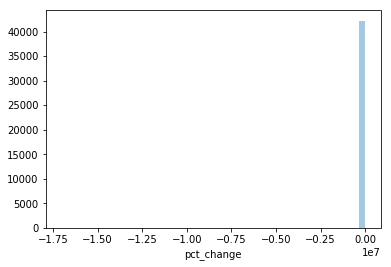

In [38]:
sns.distplot(deliv[ (pd.isnull(deliv['pct_change'])==False)
                  & (np.isinf(deliv['pct_change'])==False)]['pct_change'],kde=False)
plt.show()

In [39]:
deliv[deliv['original_units_incorrect']==1]['pct_change'].describe(percentiles=[0.05,.1,.5,.9,.95])

count    1519.000000
mean    -inf        
std     NaN         
min     -inf        
5%      -1579.248040
10%     -829.331549 
50%      0.012661   
90%      0.998590   
95%      0.999379   
max      1.000000   
Name: pct_change, dtype: float64

In [40]:
deliv[deliv['original_units_incorrect']==0]['pct_change'].describe(percentiles=[0.05,.1,.5,.9,.95])

count    4.087300e+04
mean    -inf         
std     NaN          
min     -inf         
5%      -1.094135e+00
10%     -4.256844e-01
50%      6.007487e-02
90%      4.068299e-01
95%      6.300680e-01
max      2.946909e+03
Name: pct_change, dtype: float64

In [41]:
############
# Generate train/test IDs
#################

In [42]:
pwsid = set(prod['PWSID']).intersection(set(deliv['PWSID']))
pwsid = sorted(list(pwsid))
print(len(pwsid))

2576


In [43]:
np.random.seed(seed=122)
train_indices =  np.random.choice(np.arange(0,len(pwsid)),size=int(.8*len(pwsid)),replace=False)
train_pwsid = list(np.array(pwsid)[[train_indices]])
print(len(train_pwsid))

2060


In [44]:
test_pwsid = list(set(pwsid).difference(set(train_pwsid)))
print(len(test_pwsid))

516


In [45]:
print(set(train_pwsid).intersection(test_pwsid))

set()


In [46]:
##########
# Generate train/test sets
###########

In [47]:
deliv_train_X = deliv[deliv['PWSID'].isin(train_pwsid)]
deliv_test_X = deliv[deliv['PWSID'].isin(test_pwsid)]

print(deliv_train_X.shape)
print(deliv_test_X.shape)

(60955, 54)
(14516, 54)


In [48]:
# What % of records have units reported incorrectly?
deliv_train_X['original_units_incorrect'].value_counts() / deliv_train_X.shape[0]

0    0.957756
1    0.042244
Name: original_units_incorrect, dtype: float64

In [49]:
# What % of records have units reported incorrectly?
deliv_test_X['original_units_incorrect'].value_counts() / deliv_test_X.shape[0]

0    0.964246
1    0.035754
Name: original_units_incorrect, dtype: float64

In [50]:
deliv_train_X

,PWSID,Water.System.Name,Water.System.Classification,Year,Month,Date,Days.In.Month,Delivered.Water.Units AS ORIGINALLY REPORTED,Delivered.Water.Units.Revised BY OFFICE OF INFORMATION MANAGEMENT AND ANALYSIS,UNITS ADJUSTED BY OIMA?,WATER DELIVERIES TO Single.family.Residential,WATER DELIVERIES TO Multi.family.Residential,WATER DELIVERIES TO Commercial.Institutional,WATER DELIVERIES TO Industrial,WATER DELIVERIES TO Landscape.Irrigation,WATER DELIVERIES TO Other,WATER DELIVERIES TO Agricultural,WATER DELIVERIES TO Other.PWS,"WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)","Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)",Population Of Service Area,CALCULATED GPCD (Total delivery to residential in gallons per capita day),WATER DELIVERIES TO Multi.family.Residential_numeric,WATER DELIVERIES TO Commercial.Institutional_numeric,WATER DELIVERIES TO Industrial_numeric,WATER DELIVERIES TO Landscape.Irrigation_numeric,WATER DELIVERIES TO Other_numeric,WATER DELIVERIES TO Agricultural_numeric,WATER DELIVERIES TO Other.PWS_numeric,"WATER DELIVERIES Total.Delivered Residential IN REVISED UNITS (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric","Total. RESIDENTIAL Delivered.Gallons (Total Does not include Landscape Irrigation, Agricultural or to other PWS)_numeric",original_units_incorrect,units_unavailable,key,gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons,gpcd_numeric,Water.System.Classification_mod,Community Water System,Large Water System,Local Government,NA,Nontransient Noncommunity Water System,Private,Transient Noncommunity Water System,AF,CCF,G,MG,Numer of Institutional Service Conections,prior_year,Year_prior,gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons_prior,change_from_prior,pct_change
24,CA0105008,CASTLEWOOD DOMESTIC WATER SYSTEM,Community Water System,2013,January,2013-01-01,31,G,G,NO CHANGES,"2,836,188",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,836,188.00","2,836,188.00",499.0,183.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2836188.0,2836188.00,0,0,CASTLEWOOD DOMESTIC WATER SYSTEM_2013-01-01 00:00:00,183.346564,183.3,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2012,NaN,NaN,NaN,NaN
25,CA0105008,CASTLEWOOD DOMESTIC WATER SYSTEM,Community Water System,2013,February,2013-02-01,28,G,G,NO CHANGES,"2,784,576",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,784,576.00","2,784,576.00",499.0,199.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2784576.0,2784576.00,0,0,CASTLEWOOD DOMESTIC WATER SYSTEM_2013-02-01 00:00:00,199.296879,199.3,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2012,NaN,NaN,NaN,NaN
26,CA0105008,CASTLEWOOD DOMESTIC WATER SYSTEM,Community Water System,2013,March,2013-03-01,31,G,G,NO CHANGES,"789,064",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"789,064.00","789,064.00",499.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789064.0,789064.00,0,0,CASTLEWOOD DOMESTIC WATER SYSTEM_2013-03-01 00:00:00,51.009374,51.0,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2012,NaN,NaN,NaN,NaN
27,CA0105008,CASTLEWOOD DOMESTIC WATER SYSTEM,Community Water System,2013,April,2013-04-01,30,G,G,NO CHANGES,"7,802,528",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7,802,528.00","7,802,528.00",499.0,521.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7802528.0,7802528.00,0,0,CASTLEWOOD DOMESTIC WATER SYSTEM_2013-04-01 00:00:00,521.210955,521.2,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2012,NaN,NaN,NaN,NaN
28,CA0105008,CASTLEWOOD DOMESTIC WATER SYSTEM,Community Water System,2013,May,2013-05-01,31,G,G,NO CHANGES,"5,814,496",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"5,814,496.00","5,814,496.00",499.0,375.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5814496.0,5814496.00,0,0,CASTLEWOOD DOMESTIC WATER SYSTEM_2013-05-01 00:00:00,375.880535,375.9,Community Water System,1,0,0,0,0,0,0,0,0,1,0,NaN,2012,NaN,NaN,NaN,NaN
29,CA0105008,CASTLEWOOD DOMESTIC WATER SYSTEM,Community Water System,2013,June,2013-06-01,30,G,G,NO CHANGES,"6,736,704",NaN,NaN,NaN,

In [51]:
#############
# Fit model
############# 

In [52]:
predictors = predictors + ['Numer of Institutional Service Conections','pct_change']

In [53]:
print(predictors)

['gpcd_from_water_deliv_residential_revised_units_in_orig_units_in_gallons', 'Population Of Service Area', 'Community Water System', 'Large Water System', 'Local Government', 'NA', 'Nontransient Noncommunity Water System', 'Private', 'Transient Noncommunity Water System', 'AF', 'CCF', 'G', 'MG', 'Numer of Institutional Service Conections', 'pct_change']


### Since each PWSID appears multiple times in the data set, perform a group split for CV to ensure that a unique PWSID cannot appear in both the train and test fold.

In [54]:
trainGroup = pd.DataFrame({"PWSID":train_pwsid})
np.random.seed(seed=122)
trainGroup['random'] = np.random.uniform(size=trainGroup.shape[0])
trainGroup['random_group'] = 0
trainGroup.loc[trainGroup['random'] < .2, 'random_group'] = 1
trainGroup.loc[(trainGroup['random'] < .4) & (trainGroup['random'] >= .2), 'random_group'] = 2
trainGroup.loc[(trainGroup['random'] < .6) & (trainGroup['random'] >= .4), 'random_group'] = 3
trainGroup.loc[(trainGroup['random'] < .8) & (trainGroup['random'] >= .6), 'random_group'] = 4


In [55]:
trainGroup[0:3]

,PWSID,random,random_group
0,CA4210016,0.156992,1
1,CA1010062,0.702210,4
2,CA4900974,0.261478,2


In [56]:
trainGroup['random_group'].value_counts()

3    449
2    434
0    403
1    388
4    386
Name: random_group, dtype: int64

In [57]:
print(deliv_train_X.shape)
deliv_train_X = deliv_train_X.merge(trainGroup[['PWSID','random_group']],on="PWSID")
print(deliv_train_X.shape)

(60955, 54)
(60955, 55)


In [58]:
gss = GroupShuffleSplit(n_splits=4, test_size=0.25, random_state=0)
for train, test in gss.split(deliv_train_X, deliv[deliv['PWSID'].isin(train_pwsid)]['original_units_incorrect'], groups=deliv_train_X['random_group']):
     print("%s %s" % (train, test))
        
splits = gss.split(deliv_train_X, deliv[deliv['PWSID'].isin(train_pwsid)]['original_units_incorrect'], groups=deliv_train_X['random_group'])

i=0
n_splits=5
train_is = [np.array([],dtype=int)]*n_splits
test_is = [np.array([],dtype=int)]*n_splits
for train_index,test_index in splits :
        # finding the corresponding indices of reflected training and testing sets
    train_is[i]=np.hstack((train_is[i],np.concatenate([train_index*n_splits+i for i in range(6)])))
    test_is[i]=np.hstack((test_is[i],np.concatenate([test_index*n_splits+i for i in range(6)])))
    i=i+1
    
cv=[(train_is[i],test_is[i]) for i in range(n_splits)]
        # constructing the final cross-validation iterable: list of 'n_splits' tuples;
        # each tuple contains two numpy arrays for training and testing indices respectively

[   48    49    50 ..., 60904 60905 60906] [    0     1     2 ..., 60952 60953 60954]
[   48    49    50 ..., 60904 60905 60906] [    0     1     2 ..., 60952 60953 60954]
[    0     1     2 ..., 60952 60953 60954] [   48    49    50 ..., 60904 60905 60906]
[    0     1     2 ..., 60952 60953 60954] [   48    49    50 ..., 60904 60905 60906]


### Parameter Tuning

In [59]:
xgb_train_X = deliv_train_X[predictors].as_matrix()
xgb_test_X = deliv_test_X[predictors].as_matrix()

xgb_train_y = deliv_train_X['original_units_incorrect']
xgb_test_y = deliv_test_X['original_units_incorrect']

In [60]:
ratio = float(np.sum(xgb_train_y == 0)) / np.sum(xgb_train_y == 1)
print(ratio)

22.6718446602


In [61]:
parameters = {'learning_rate': [0.01,0.05], #so called `eta` value
              'max_depth': [3,4,5,6],
              'min_child_weight': [1,3,5],
              'silent': [1],
              'n_estimators': [100,250], #number of trees, change it to 1000 for better results
              'seed': [1337],
             'scale_pos_weight' :[ratio]}

In [62]:
gbm = xgb.XGBClassifier(scale_pos_weight=ratio)

In [63]:
scores = ['precision', 'recall']

grid_search_results = []

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_2 = GridSearchCV(gbm, parameters, n_jobs=5, scoring='%s_weighted' % score,verbose=2, 
                 refit=True,iid=False,
                 cv=list(gss.split(deliv_train_X, deliv[deliv['PWSID'].isin(train_pwsid)]['original_units_incorrect'], 
                                   groups=deliv_train_X['random_group'])) )
    clf_2.fit(xgb_train_X, xgb_train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf_2.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf_2.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))
        print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = xgb_test_y, clf_2.predict(xgb_test_X)
    print(classification_report(y_true, y_pred))
    print()
    
    grid_search_results = grid_search_results + [clf_2,]

# Tuning hyper-parameters for precision

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.3s
[CV]  learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=

[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.3s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  16.5s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.3s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.1min


[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.9s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.9s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  15.8s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.8s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_e

[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  19.0s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  19.1s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  16.1s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   8.4s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_e

[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   4.3s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.2s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.3s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   4.3s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_e

[CV]  learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.4s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.8s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.4s
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.8s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_e

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.2min


[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  17.1s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  15.7s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.0s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.9s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=5, n_e

[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  19.7s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   7.9s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  17.2s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.2s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_e

[Parallel(n_jobs=5)]: Done 192 out of 192 | elapsed:  6.8min finished


Best parameters set found on development set:

{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

Grid scores on development set:

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.979 (+/-0.001) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.979 (+/-0.001) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.978 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weig

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   4.2s
[CV] learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, 

[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.6s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.5s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   53.0s


[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.0s
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.1s
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.1s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.2s
[CV] learning_rate=0.01, max_depth=4, min_child_weight=3, n_e

[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  16.8s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  16.8s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.8s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.8s
[CV] learning_rate=0.01, max_depth=5, min_child_weight=5, n_e

[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   4.2s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.1s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  14.1s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   4.3s
[CV] learning_rate=0.05, max_depth=3, min_child_weight=1, n_e

[CV]  learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.3s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.6s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.4s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  13.8s
[CV] learning_rate=0.05, max_depth=4, min_child_weight=3, n_e

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  4.9min


[CV]  learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  15.9s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.9s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   5.9s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.5s
[CV] learning_rate=0.05, max_depth=5, min_child_weight=5, n_e

[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   8.0s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 -  16.9s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.2s
[CV] learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=250, scale_pos_weight=22.6718446602, seed=1337, silent=1 
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=100, scale_pos_weight=22.6718446602, seed=1337, silent=1 -   6.1s
[CV]  learning_rate=0.05, max_depth=6, min_child_weight=5, n_

[Parallel(n_jobs=5)]: Done 192 out of 192 | elapsed:  6.5min finished


Best parameters set found on development set:

{'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

Grid scores on development set:

0.952 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.965 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.952 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.965 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}

0.952 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weig

### Fit model with best parameters

In [71]:
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
best_parameters = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 250, 
 'scale_pos_weight': 22.671844660194175, 'seed': 1337, 'silent': 1}
gbm = xgb.XGBClassifier(**best_parameters).fit(xgb_train_X, xgb_train_y)
predictions = gbm.predict(xgb_test_X)

In [72]:
accuracy = accuracy_score(xgb_test_y,  gbm.predict(xgb_test_X))

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.14%


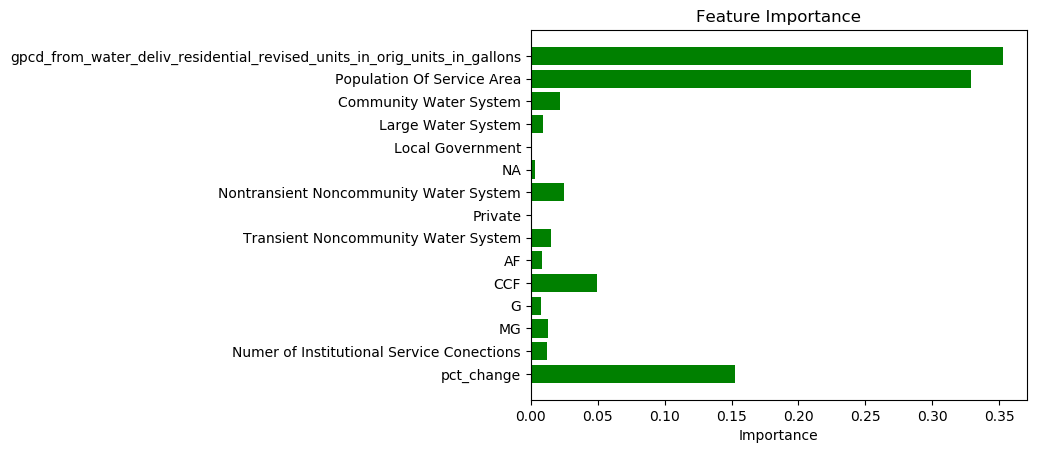

In [73]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(predictors))
ax.barh(y_pos, gbm.feature_importances_, align='center',
        color='green', ecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(predictors)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')

plt.show()

### Explore precision/recall

In [74]:
def getPrecisionRecallDF(y,X):
    precision, recall, thresholds = precision_recall_curve( y,  list(pd.DataFrame(gbm.predict_proba(X))[0]))
    thresholds = [0,] + list(thresholds)
    precisionRecallDF = pd.DataFrame({"precision":precision,"recall":recall,"threshold":thresholds})
    precisionRecallDF['fl'] = 2*((precisionRecallDF['precision']*precisionRecallDF['recall'])/(precisionRecallDF['precision']+precisionRecallDF['recall']))
    return precisionRecallDF

In [75]:
precisionRecall_test = getPrecisionRecallDF(xgb_test_y,xgb_test_X)
print(max(precisionRecall_test['fl']))

precisionRecall_train = getPrecisionRecallDF(xgb_train_y,xgb_train_X)
print(max(precisionRecall_train['fl']))

0.0690389092118
0.0810640642216


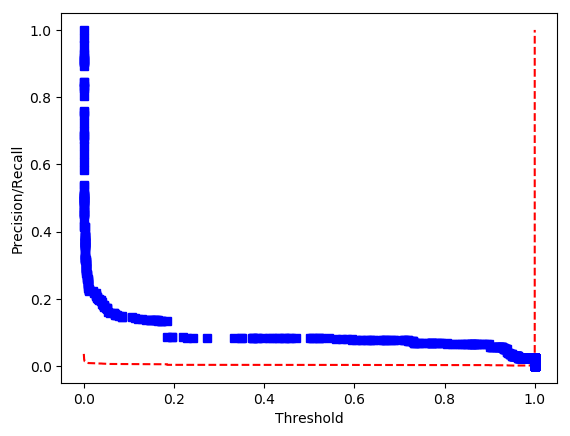

In [76]:
plt.plot(precisionRecall_test['threshold'], precisionRecall_test['precision'], 'r--', precisionRecall_test['threshold'], precisionRecall_test['recall'], 'bs')
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.show()
# Recall: Of the records in incorrect units, what % are predicted to be incorrect?
# Precision:  Of the recorsd PREDICTED to be in incorrect units, what % are predicted tobe incorrect?
# Precision is low, but I have few examples of 

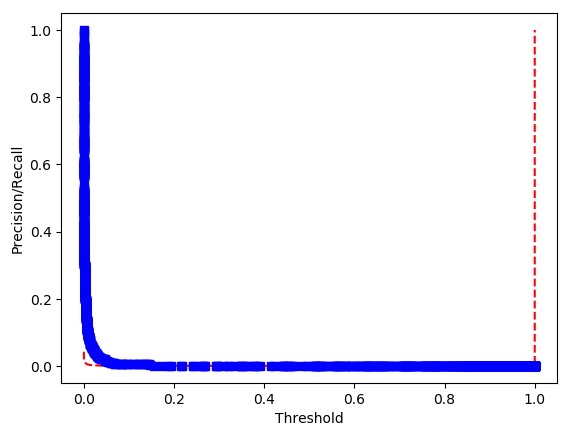

In [77]:
plt.plot(precisionRecall_train['threshold'], precisionRecall_train['precision'], 'r--', 
         precisionRecall_train['threshold'], precisionRecall_train['recall'], 'bs')
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.show()

### Explore how variables are associated with outcome

In [ ]:
explainer = shap.TreeExplainer(gbm)
shap_values = shap.TreeExplainer(gbm).shap_values(xgb_train_X)


In [ ]:
shap.summary_plot(shap_values, xgb_train_X)

In [ ]:
print( deliv_train_X[predictors].columns.values[0]+ ":  ") 
print( deliv_train_X[predictors].columns.values[1]+ ":  ") 
print( deliv_train_X[predictors].columns.values[12]+ ": ") 
print( deliv_train_X[predictors].columns.values[9]+ ": ") 
print( deliv_train_X[predictors].columns.values[14]+ ": ") 

In [ ]:
shap.dependence_plot(0, shap_values[0:100], xgb_train_X[0:100])
print( deliv_train_X[predictors].columns.values[0]+ "") 
print( deliv_train_X[predictors].columns.values[9]+ "") 

In [ ]:
shap_interaction_values = shap.TreeExplainer(gbm).shap_interaction_values(xgb_train_X)

In [ ]:
shap.dependence_plot(
    (0, 0),
    shap_interaction_values, xgb_train_X,
    display_features=xgb_train_X
)